# Imports

In [2]:
import os
import random
import pickle
import datetime
from multiprocessing import Process, Pool

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Load pickled graphs

In [30]:
graphs_dir = '/path/to/dir/with/graphs'
graphs = []
cities_in_dataset = set()
for file in os.listdir(graphs_dir):
    if not file.startswith('CAMDA'):
        print(f'skipping {file}')
        continue
    print(f'reading {file}')
    city_code = os.path.splitext(file)[0].split('_')[3]
    cities_in_dataset.add(city_code)
    with open(os.path.join(graphs_dir, file), 'rb') as f:
        graph = pickle.load(f)
    graphs.append(graph)

skipping SCL.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_017_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_ILR_022_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD17_HKG_010_1_kneaddata_subsampled_20_percent.labeled_graph_max
skipping HKG.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_012_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_020_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_SCL_009_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_DOH_044_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_009_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_026_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_024_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_DOH_013_

## Peek at the objects

In [31]:
print(cities_in_dataset)

{'DOH', 'ILR', 'HKG', 'BCN', 'FAI', 'SCL'}


In [16]:
print(f'{graphs[0] = } | with label {graphs[0].y.item()}')

graphs[0] = Data(x=[512, 25], edge_index=[2, 2161], weight=[2161], y=[1]) | with label 1


In [17]:
print(f'{graphs[1] = } | with label {graphs[1].y.item()}')

graphs[1] = Data(x=[561, 25], edge_index=[2, 2343], weight=[2343], y=[1]) | with label 3


In [19]:
graphs_n = len(graphs)
print(f'total graphs num = {graphs_n}')

total graphs num = 12


# Train GCN

## Data Loaders

In [56]:
random.shuffle(graphs)
split_value = 0.8
train_dataset = graphs[:int(graphs_n * split_value)]
val_dataset = graphs[int(graphs_n * split_value):]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [57]:
print(f'batches in train dataset = {len(train_loader)}')
print(f'batches in validation dataset = {len(val_loader)}')

batches in train dataset = 1
batches in validation dataset = 3


## Model architecture

In [58]:
# TODO: improve architecture: add more layers, test other readout functions, etc.
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_weight, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [59]:
# ---------- these magic numbers were used during graph construction ---------- #
kmer_len = 4
subkmer_len = 2
num_features = 5**subkmer_len # length of each node's feature vector
# ------ num_features is needed to match the shape of the first layer in GCN --- #

In [60]:
print(cities_in_dataset)
num_classes = len(cities_in_dataset)

{'DOH', 'ILR', 'HKG', 'BCN', 'FAI', 'SCL'}


In [61]:
# initialize the model, optimizer, and loss function
model = GCN(num_features=num_features, hidden_channels=32, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [62]:
# train function
def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.weight, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return total_loss / len(train_loader), correct / len(train_dataset)

# validation function
def validate(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.weight, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [63]:
# training loop
train_loss_for_plot = []
train_acc_for_plot = []
val_acc_for_plot = []

num_epochs = 2000
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_acc = validate(val_loader)
    train_loss_for_plot.append(train_loss)
    train_acc_for_plot.append(train_acc)
    val_acc_for_plot.append(val_acc)
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1, Train Loss: 1.7641, Train Acc: 0.3333, Val Acc: 0.3333
Epoch 101, Train Loss: 1.2575, Train Acc: 0.4444, Val Acc: 0.0000
Epoch 201, Train Loss: 0.5850, Train Acc: 0.7778, Val Acc: 0.0000
Epoch 301, Train Loss: 0.5879, Train Acc: 0.6667, Val Acc: 0.0000
Epoch 401, Train Loss: 0.3459, Train Acc: 0.7778, Val Acc: 0.3333
Epoch 501, Train Loss: 0.1192, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 601, Train Loss: 0.0670, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 701, Train Loss: 0.1661, Train Acc: 0.8889, Val Acc: 0.3333
Epoch 801, Train Loss: 0.0268, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 901, Train Loss: 0.0593, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 1001, Train Loss: 0.1738, Train Acc: 0.8889, Val Acc: 0.3333
Epoch 1101, Train Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 1201, Train Loss: 0.0317, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 1301, Train Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 1401, Train Loss: 0.0026, Train Acc: 1.0000, Val Acc: 0.3333
Epoch 1

In [64]:
import matplotlib.pyplot as plt
import matplotlib as mpl

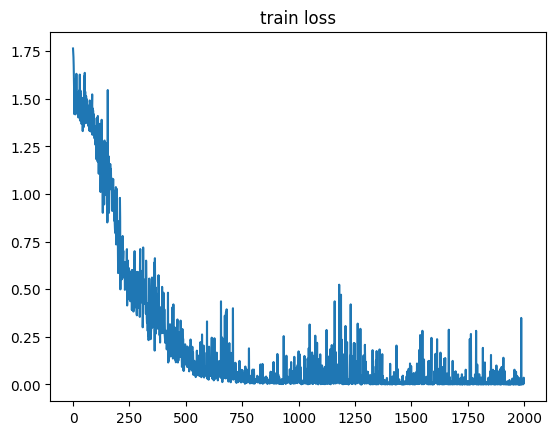

In [68]:
plt.plot(train_loss_for_plot)
plt.title('train loss')
plt.show()

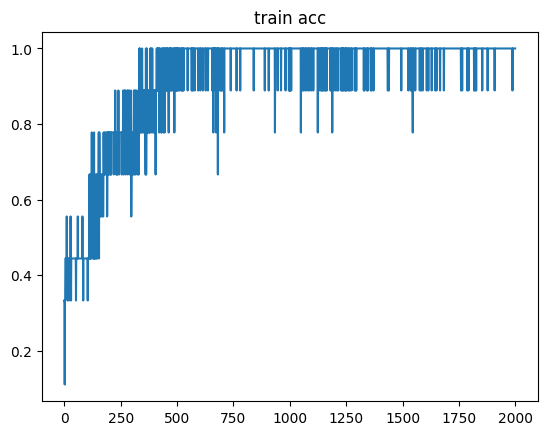

In [69]:
plt.plot(train_acc_for_plot)
plt.title('train acc')
plt.show()

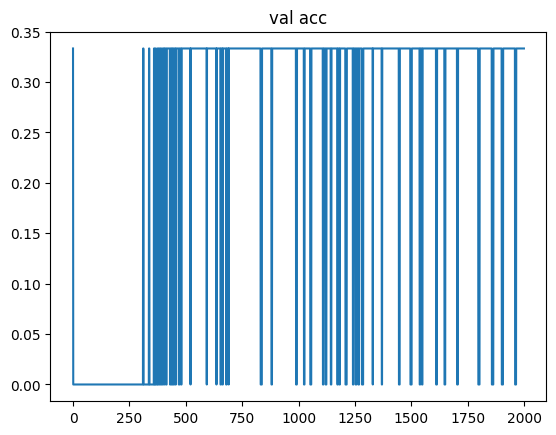

In [70]:
plt.plot(val_acc_for_plot)
plt.title('val acc')
plt.show()

Conclusion: the validation dataset is **too small**. The model seems to be able to capture the relationship between the graph structure (supplied with edge weights and node attributes) but **fails** to generalize on unseen samples, which is only natural.

Next steps: 
* collect larger dataset
* improve network architecture
* add more features to graph edges and nodes (+ literature review on best practices)